### Assignment 1

Submission should be in a Jupyter note book (.ipynb)

1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement for negative numbers. The function signature is 

   ```python
   def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
   # w: width of the binary representation
   # b: binary point
   ```
   Test the following inputs
   ```python
   fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
   ```
   ```python
   fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
   ```
   ```python
   fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])
   ```
   


2. Calculate the price of the following questions step by step using two step Cox Rox Rubinstein (CRR) Binomial tree

    a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)? 

    Note: Don't use codes to generate numbers. Calcualte them manually.
    

3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
    * Rho: the rate of change in the price of an option in response to a change in the interest rate.
    
  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

  \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} , ~~~ choose ~~~ \Delta S ~~~ appropriately!\\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
    & \rho = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
  \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2, t = 0, T = 1$, plot each greeks as a function of strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

  Please only show one graph for each Greek for European and American put option.  Total 12 graphs : (price, delta, gamma, vega, theta, rho) *(European, American Put Option).

# **ANS**


## **1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement for negative numbers. The function signature is**

In [1]:
def fromFixedPoint(w: int, b: int, bits: [int]) -> float:
    """
    Converts a fixed-point binary representation to a floating-point number.

    Parameters
    ----------
    w : int
        The total width (number of bits) of the binary representation.
    b : int
        The position of the binary point (number of fractional bits).
    bits : [int]
        A list of integers representing the binary digits

    Returns
    -------
    float
        The floating-point representation of the fixed-point number.
    """
    # w: width of the binary representation
    # b: binary point
    ans = 0
    decimal = w - b
    if bits[0] != 0:
        ans -= 2 ** (decimal - 1)

    for i in range(1, decimal):
        ans += bits[i] * 2 ** (decimal - i - 1)
    for i in range(b):
        ans += bits[decimal + i] * 2 ** -(i + 1)
    return ans


print(fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0]))
print(fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1]))
print(fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1]))

44.75
-13.28125
-21.25


## **2. Calculate the price of the following questions step by step using two step Cox Rox Rubinstein (CRR) Binomial tree**

**a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$**

$b = e^{\sigma^2 t + rt} + e^{-rt} = e^{(0.2^2 \cdot \frac{1}{2} + 0.03 \cdot \frac{1}{2})} + e^{-0.03 \cdot \frac{1}{2}} = 2.020731648 \quad$\
$u = \frac{b + \sqrt{b^2 - 4}}{2} = \frac{2.020731648 + \sqrt{(2.020731648)^2 - 4}}{2} = 1.154723362 \quad$\
$p = \frac{e^{rt} - \frac{1}{u}}{u - \frac{1}{u}} = \frac{e^{0.03 \cdot \frac{1}{2}} - \frac{1}{1.154723362}}{1.154723362 - \frac{1}{1.154723362}} = 0.5164426482\quad$

$\text{final node 0} = \max(S_T - K, 0) = \max(S_0 u^2 - K, 0) = \max(100 \cdot 1.154723362^2 - 105, 0) = 28.33860427 \quad$\
$\text{final node 1} = \max(S_T - K, 0) = \max(S_0 u d - K, 0) = \max(100 \cdot 1.154723362 \cdot 1.154723362^{-1} - 105, 0) = 0 \quad$\
$\text{final node 2} = \max(S_T - K, 0) = \max(S_0 d^2 - K, 0) = \max(100 \cdot 1.154723362^{-2} - 105, 0) = 0$

$T_1 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5164426482 \cdot 28.33860427 + (1-0.5164426482) \cdot 0]  = 14.41737315$\
$T_1 \text{node 1} = e^{-0.03 \cdot \frac{1}{2}} [0.5164426482 \cdot 0 + (1-0.5164426482) \cdot 0]  = 0$

$T_0 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5164426482 \cdot 14.41737315 + (1-0.5164426482) \cdot 0]  = 7.334893646$

$V_0 = 7.334893646$

**b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$**

$b = e^{\sigma^2 t + rt} + e^{-rt} = e^{(0.2^2 \cdot \frac{1}{2} + 0.03 \cdot \frac{1}{2})} + e^{-0.03 \cdot \frac{1}{2}} = 2.020731648402686 \quad$\
$u = \frac{b + \sqrt{b^2 - 4}}{2} = \frac{2.020731648402686 + \sqrt{(2.020731648402686)^2 - 4}}{2} = 1.1547233619818793 \quad$\
$p = \frac{e^{rt} - \frac{1}{u}}{u - \frac{1}{u}} = \frac{e^{0.03 \cdot \frac{1}{2}} - \frac{1}{1.1547233619818793}}{1.1547233619818793 - \frac{1}{1.1547233619818793}} = 0.5164426481892243\quad$

$\text{final node 0} = \max(K - S_T, 0) = \max(K - S_0 u^2, 0) = \max(105 - 100 \cdot 1.1547233619818793^2, 0) = 0 \quad$\
$\text{final node 1} = \max(K - S_T, 0) = \max(K - S_0 u d, 0) = \max(105 - 100 \cdot 1.1547233619818793 \cdot 1.1547233619818793^{-1}, 0) = 5.0 \quad$\
$\text{final node 2} = \max(K - S_T, 0) = \max(K - S_0 d^2, 0) = \max(105 - 100 \cdot 1.1547233619818793^{-2}, 0) = 30.002964785049826$

$T_1 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5164426481892243 \cdot 0 + (1-0.5164426481892243) \cdot 5.0]  = 2.3817906037581693$\
$T_1 \text{node 1} = e^{-0.03 \cdot \frac{1}{2}} [0.5164426481892243 \cdot 5.0 + (1-0.5164426481892243) \cdot 30.002964785049826]  = 16.835925016240928$

$T_0 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5164426481892243 \cdot 2.3817906037581693 + (1-0.5164426481892243) \cdot 16.835925016240928]  = 9.231674667218368$

$V_0 = 9.231674667218368$



**c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$**

$b = e^{\sigma^2 t + rt} + e^{-rt} = e^{(0.1^2 \cdot \frac{1}{2} + 0.03 \cdot \frac{1}{2})} + e^{-0.03 \cdot \frac{1}{2}} = 2.0053132796298185 \quad$\
$u = \frac{b + \sqrt{b^2 - 4}}{2} = \frac{2.0053132796298185 + \sqrt{(2.0053132796298185)^2 - 4}}{2} = 1.0755972825658795 \quad$\
$p = \frac{e^{rt} - \frac{1}{u}}{u - \frac{1}{u}} = \frac{e^{0.03 \cdot \frac{1}{2}} - \frac{1}{1.0755972825658795}}{1.0755972825658795 - \frac{1}{1.0755972825658795}} = 0.5853874076990085\quad$

$\text{final node 0} = \max(S_T - K, 0) = \max(S_0 u^2 - K, 0) = \max(100 \cdot 1.0755972825658795^2 - 105, 0) = 10.690951426310448 \quad$\
$\text{final node 1} = \max(S_T - K, 0) = \max(S_0 u d - K, 0) = \max(100 \cdot 1.0755972825658795 \cdot 1.0755972825658795^{-1} - 105, 0) = 0 \quad$\
$\text{final node 2} = \max(S_T - K, 0) = \max(S_0 d^2 - K, 0) = \max(100 \cdot 1.0755972825658795^{-2} - 105, 0) = 0$

$T_1 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5853874076990085 \cdot 10.690951426310448 + (1-0.5853874076990085) \cdot 0]  = 6.1651736731937845$\
$T_1 \text{node 1} = e^{-0.03 \cdot \frac{1}{2}} [0.5853874076990085 \cdot 0 + (1-0.5853874076990085) \cdot 0]  = 0$

$T_0 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5853874076990085 \cdot 6.1651736731937845 + (1-0.5853874076990085) \cdot 0]  = 3.555283800757024$

$V_0 = 3.555283800757024$

**d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$**

$b = e^{\sigma^2 t + rt} + e^{-rt} = e^{(0.1^2 \cdot \frac{1}{2} + 0.03 \cdot \frac{1}{2})} + e^{-0.03 \cdot \frac{1}{2}} = 2.0053132796298185 \quad$\
$u = \frac{b + \sqrt{b^2 - 4}}{2} = \frac{2.0053132796298185 + \sqrt{(2.0053132796298185)^2 - 4}}{2} = 1.0755972825658795 \quad$\
$p = \frac{e^{rt} - \frac{1}{u}}{u - \frac{1}{u}} = \frac{e^{0.03 \cdot \frac{1}{2}} - \frac{1}{1.0755972825658795}}{1.0755972825658795 - \frac{1}{1.0755972825658795}} = 0.5853874076990085\quad$

$\text{final node 0} = \max(K - S_T, 0) = \max(K - S_0 u^2, 0) = \max(105 - 100 \cdot 1.0755972825658795^2, 0) = 0 \quad$\
$\text{final node 1} = \max(K - S_T, 0) = \max(K - S_0 u d, 0) = \max(105 - 100 \cdot 1.0755972825658795 \cdot 1.0755972825658795^{-1}, 0) = 5.0 \quad$\
$\text{final node 2} = \max(K - S_T, 0) = \max(K - S_0 d^2, 0) = \max(105 - 100 \cdot 1.0755972825658795^{-2}, 0) = 18.562816480340572$

$T_1 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5853874076990085 \cdot 0 + (1-0.5853874076990085) \cdot 5.0]  = 2.0421990749274177$\
$T_1 \text{node 1} = e^{-0.03 \cdot \frac{1}{2}} [0.5853874076990085 \cdot 5.0 + (1-0.5853874076990085) \cdot 18.562816480340572]  = 10.465153951927684$

$T_0 \text{node 0} = e^{-0.03 \cdot \frac{1}{2}} [0.5853874076990085 \cdot 2.0421990749274177 + (1-0.5853874076990085) \cdot 10.465153951927684]  = 5.452064823350394$

$V_0 = 5.452064823350394$

## **What is the value of the portfolio that is long (a) and short (b)?**
<font color='red'> Value = 7.334893646 - 9.231674667218368 = -1.8967810212183673 </font> 

## **How about the portfolio that long (c) and short (d)?**
<font color='red'> Value = 3.555283800757024 - 5.452064823350394 = -1.8967810225933701 </font> 


## **3. Please only show one graph for each Greek for European and American put option.  Total 12 graphs : (price, delta, gamma, vega, theta, rho) \*(European, American Put Option).**

In [2]:
import math
from enum import Enum, IntEnum
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba.experimental import jitclass
from numba import int8, float64
from numba import njit

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.figsize"] = [30, 15]

In [3]:
# binomial pricer for exercise 3
class PayoffType(IntEnum):
    Call = 0
    Put = 1


spec_option = [("expiry", float64), ("strike", float64), ("payoffType", int8)]


@jitclass(spec_option)
class EuropeanOption:
    """Represents a European option contract.

    Parameters
    ----------
    expiry : float
        The time to expiry of the option, in years.
    strike : float
        The strike price of the option.
    payoffType : PayoffType
        The type of the option payoff (Call or Put).

    Methods
    -------
    payoff(S)
        Calculates the payoff of the option at a given spot price.
    valueAtNode(t, S, continuation)
        Calculates the option value at a given node in the binomial tree (for European option).
    """

    def __init__(self, expiry: float, strike: float, payoffType: PayoffType):
        """
        Initializes a EuropeanOption object.

        Parameters
        ----------
        expiry : float
            The time to expiry of the option, in years.
        strike : float
            The strike price of the option.
        payoffType : PayoffType
            The type of the option payoff (Call or Put).
        """
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType

    def payoff(self, S: float) -> float:
        """
        Calculates the payoff of the option.

        Parameters
        ----------
        S : float
            The spot price of the underlying asset.

        Returns
        -------
        float
            The payoff of the option.
        """
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)

    def valueAtNode(self, t: float, S: float, continuation: float) -> float:
        """
        Calculates the option value at a given node.  For European options,
        this is simply the continuation value.

        Parameters
        ----------
        t : float
            The time at the node.
        S : float
            The spot price at the node.
        continuation : float
            The continuation value from the next time step.

        Returns
        -------
        float
            The value of the option at the node.
        """
        return continuation


@jitclass(spec_option)
class AmericanOption:
    """Represents an American option contract.

    Parameters
    ----------
    expiry : float
        The time to expiry of the option, in years.
    strike : float
        The strike price of the option.
    payoffType : PayoffType
        The type of the option payoff (Call or Put).

    Methods
    -------
    payoff(S)
        Calculates the payoff of the option at a given spot price.
    valueAtNode(t, S, continuation)
        Calculates the option value at a given node in the binomial tree (for American option).
    """

    def __init__(self, expiry: float, strike: float, payoffType: PayoffType):
        """
        Initializes an AmericanOption object.

        Parameters
        ----------
        expiry : float
            The time to expiry of the option, in years.
        strike : float
            The strike price of the option.
        payoffType : PayoffType
            The type of the option payoff (Call or Put).
        """
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType

    def payoff(self, S: float) -> float:
        """
        Calculates the payoff of the option.

        Parameters
        ----------
        S : float
            The spot price of the underlying asset.

        Returns
        -------
        float
            The payoff of the option.
        """
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)

    def valueAtNode(self, t: float, S: float, continuation: float) -> float:
        """
        Calculates the option value at a given node. This considers both
        the payoff from immediate exercise and the continuation value.

        Parameters
        ----------
        t : float
            The time at the node.
        S : float
            The spot price at the node.
        continuation : float
            The continuation value from the next time step.

        Returns
        -------
        float
            The value of the option at the node.
        """
        return max(self.payoff(S), continuation)


@njit
def crrCalib(r: float, vol: float, t: float) -> tuple[float, float, float]:
    """
    Calibrates the binomial tree parameters using the Cox-Ross-Rubinstein (CRR) method.

    Parameters
    ----------
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    t : float
        The time step size.

    Returns
    -------
    tuple
        A tuple containing the up factor (u), down factor (d), and risk-neutral probability (p).
    """
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1 / u, p)


@njit
def jrrnCalib(r: float, vol: float, t: float) -> tuple[float, float, float]:
    """
    Calibrates the binomial tree parameters using the Jarrow-Rudd with Normalization (JRRn) method.

    Parameters
    ----------
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    t : float
        The time step size.

    Returns
    -------
    tuple
        A tuple containing the up factor (u), down factor (d), and risk-neutral probability (p).
    """
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)


@njit
def jreqCalib(r: float, vol: float, t: float) -> tuple[float, float, float]:
    """
    Calibrates the binomial tree parameters using the Jarrow-Rudd with Equal Probabilities (JReq) method.

    Parameters
    ----------
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    t : float
        The time step size.

    Returns
    -------
    tuple
        A tuple containing the up factor (u), down factor (d), and risk-neutral probability (p).
    """
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1 / 2)


@njit
def tianCalib(r: float, vol: float, t: float) -> tuple[float, float, float]:
    """
    Calibrates the binomial tree parameters using the Tian method.

    Parameters
    ----------
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    t : float
        The time step size.

    Returns
    -------
    tuple
        A tuple containing the up factor (u), down factor (d), and risk-neutral probability (p).
    """
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v * v + 2 * v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v * v + 2 * v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)


@njit
def binomialPricer(
    S: float,
    r: float,
    vol: float,
    trade: EuropeanOption | AmericanOption,
    n: int,
    calib: callable,
) -> float:
    """
    Prices an option using a binomial tree method.

    Parameters
    ----------
    S : float
        The initial stock price.
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    trade : EuropeanOption or AmericanOption
        The option contract to price.
    n : int
        The number of time steps in the binomial tree.
    calib : callable
        The calibration function to use (e.g., crrCalib, jrrnCalib).

    Returns
    -------
    float
        The option price.
    """
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d**i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d**j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [4]:
class Greeks(str, Enum):
    """
    Enumerates the different greeks that can be calculated for an option.

    Attributes
    ----------
    delta : str
        Sensitivity of the option price to a change in the underlying asset price.
    gamma : str
        Sensitivity of delta to a change in the underlying asset price.
    vega : str
        Sensitivity of the option price to a change in the volatility of the underlying asset.
    theta : str
        Sensitivity of the option price to the passage of time.
    rho : str
        Sensitivity of the option price to a change in the risk-free interest rate.
    """

    delta = "delta"
    gamma = "gamma"
    vega = "vega"
    theta = "theta"
    rho = "rho"


class optionType(str, Enum):
    """
    Enumerates the types of options that are supported.

    Attributes
    ----------
    european : str
        European option.
    american : str
        American option.
    """

    european = "european"
    american = "american"


class greeks_calculator:
    """
    Calculates the Greeks (delta, gamma, vega, theta, rho) for an option using a binomial pricer.

    Parameters
    ----------
    option : optionType
        The type of option ('european' or 'american').
    payoffType : PayoffType
        The payoff type of the option (Call or Put).
    T : float
        The time to expiry of the option, in years.
    pricer : callable
        The option pricer function (e.g., binomialPricer).
    S : float
        The initial stock price.
    strike : float
        The strike price of the option.
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    n : int
        The number of time steps to use in the pricer.
    calib : callable
        The calibration function to use (e.g., crrCalib, jrrnCalib).

    Attributes
    ----------
    pricer : callable
        The option pricer function.
    greek_functions : dict
        A dictionary mapping greek types (Greeks enum) to their corresponding calculation functions.
    S : float
        The initial stock price.
    r : float
        The risk-free interest rate.
    vol : float
        The volatility of the underlying asset.
    n : int
        The number of time steps to use in the pricer.
    calib : callable
        The calibration function to use.
    trade : EuropeanOption or AmericanOption
        The option contract.
    price : float
        The initial option price.

    Methods
    -------
    delta(sensitivity=0.001) -> float
        Calculates the delta of the option.
    gamma(sensitivity=0.15) -> float
        Calculates the gamma of the option.
    vega(sensitivity=0.001) -> float
        Calculates the vega of the option.
    theta(sensitivity=0.004) -> float
        Calculates the theta of the option.
    rho(sensitivity=0.0001) -> float
        Calculates the rho of the option.
    binomialGreeks(greekType: Greeks) -> float
        Calculates the specified greek.

    """

    def __init__(
        self,
        option: optionType,
        payoffType: PayoffType,
        T: float,
        pricer: callable,
        S: float,
        strike: float,
        r: float,
        vol: float,
        n: int,
        calib: callable,
    ):
        """
        Initializes the greeks_calculator.

        Parameters
        ----------
        option : optionType
            The type of option ('european' or 'american').
        payoffType : PayoffType
            The payoff type of the option (Call or Put).
        T : float
            The time to expiry of the option, in years.
        pricer : callable
            The option pricer function (e.g., binomialPricer).
        S : float
            The initial stock price.
        strike : float
            The strike price of the option.
        r : float
            The risk-free interest rate.
        vol : float
            The volatility of the underlying asset.
        n : int
            The number of time steps to use in the pricer.
        calib : callable
            The calibration function to use (e.g., crrCalib, jrrnCalib).
        """
        self.pricer: callable = pricer
        self.greek_functions: dict = {
            Greeks.delta: self.delta,
            Greeks.gamma: self.gamma,
            Greeks.vega: self.vega,
            Greeks.theta: self.theta,
            Greeks.rho: self.rho,
        }

        self.S: float = S
        self.r: float = r
        self.vol: float = vol
        self.n: int = n
        self.calib: callable = calib

        if option == optionType.european:
            self.trade = EuropeanOption(expiry=T, strike=strike, payoffType=payoffType)
        if option == optionType.american:
            self.trade = AmericanOption(expiry=T, strike=strike, payoffType=payoffType)

        self.price: float = self.pricer(
            S=self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )

    def delta(self, sensitivity: float = 0.001) -> float:
        """
        Calculates the delta of the option.

        Delta is the sensitivity of the option price to a small change in the
        underlying asset's price.  It is calculated using a finite difference
        method.

        Parameters
        ----------
        sensitivity : float, optional
            The percentage change in the underlying asset price used to
            approximate the derivative.  Defaults to 0.001 (0.1%).

        Returns
        -------
        float
            The delta of the option.
        """
        price_up: float = self.pricer(
            S=self.S + sensitivity * self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        price_down: float = self.pricer(
            S=self.S - sensitivity * self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        delta: float = (price_up - price_down) / (2 * sensitivity * self.S)
        return delta

    def gamma(self, sensitivity: float = 0.15) -> float:
        """
        Calculates the gamma of the option.

        Gamma is the sensitivity of delta to a change in the underlying asset's
        price.  It is calculated using a finite difference method.

        Parameters
        ----------
        sensitivity : float, optional
            The percentage change in the underlying asset price used to
            approximate the second derivative. Defaults to 0.15 (15%).

        Returns
        -------
        float
            The gamma of the option.
        """
        price: float = self.pricer(
            S=self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        price_up: float = self.pricer(
            S=self.S + sensitivity * self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        price_down: float = self.pricer(
            S=self.S - sensitivity * self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        gamma: float = (price_up - 2 * price + price_down) / (sensitivity * self.S) ** 2
        return gamma

    def vega(self, sensitivity: float = 0.001) -> float:
        """
        Calculates the vega of the option.

        Vega is the sensitivity of the option price to a change in the
        volatility of the underlying asset.  It is calculated using a finite
        difference method.  Note that Vega is often expressed as a value
        per 1% change in volatility.

        Parameters
        ----------
        sensitivity : float, optional
            The percentage change in volatility used to approximate the
            derivative.  Defaults to 0.001 (0.1%).

        Returns
        -------
        float
            The vega of the option.
        """
        price_up: float = self.pricer(
            S=self.S,
            r=self.r,
            vol=self.vol + sensitivity * self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        price_down: float = self.pricer(
            S=self.S,
            r=self.r,
            vol=self.vol - sensitivity * self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        vega: float = (price_up - price_down) / (2 * sensitivity * self.vol)
        return vega

    def theta(self, sensitivity: float = 0.004) -> float:
        """
        Calculates the theta of the option.

        Theta is the sensitivity of the option price to the passage of time.
        It is calculated using a finite difference method, where the expiry
        date of the option is adjusted. Theta is often expressed as a value
        per day.  The sensitivity parameter represents the time step in
        years.

        Parameters
        ----------
        sensitivity : float, optional
            The time step (in years) used to approximate the derivative.
            Defaults to 0.004 (approximately 1 day, assuming 250 trading days).

        Returns
        -------
        float
            The theta of the option.
        """
        price_up: float = self.pricer(
            S=self.S,
            r=self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )

        trade2 = self.trade
        trade2.expiry -= sensitivity

        price_down: float = self.pricer(
            S=self.S,
            r=self.r,
            vol=self.vol,
            trade=trade2,
            n=self.n,
            calib=self.calib,
        )
        theta: float = (price_up - price_down) / sensitivity
        return theta

    def rho(self, sensitivity: float = 0.0001) -> float:
        """
        Calculates the rho of the option.

        Rho is the sensitivity of the option price to a change in the
        risk-free interest rate.  It is calculated using a finite difference
        method.

        Parameters
        ----------
        sensitivity : float, optional
            The change in the interest rate used to approximate the derivative.
            Defaults to 0.0001 (0.01%).

        Returns
        -------
        float
            The rho of the option.
        """
        price_up: float = self.pricer(
            S=self.S,
            r=self.r + sensitivity * self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        price_down: float = self.pricer(
            S=self.S,
            r=self.r - sensitivity * self.r,
            vol=self.vol,
            trade=self.trade,
            n=self.n,
            calib=self.calib,
        )
        rho: float = (price_up - price_down) / (2 * sensitivity * self.r)
        return rho

    def binomialGreeks(self, greekType: Greeks) -> float:
        """
        Calculates a specific greek for the option.

        Parameters
        ----------
        greekType : Greeks
            The type of greek to calculate (e.g., Greeks.delta, Greeks.gamma).

        Returns
        -------
        float
            The value of the specified greek.

        Raises
        ------
        Exception
            If the greekType is not supported.
        """
        if greekType in self.greek_functions:
            return self.greek_functions[greekType]()
        else:
            raise Exception("greekType not supported: ", greekType)

In [5]:
S, r, vol, t, T, n = 100, 0.03, 0.2, 0, 1, 5_000
strikes = [i for i in range(50, 151)]
payoff = PayoffType.Put

price = {f"{option}_{payoff}": [] for option in optionType}
greeks_dict = {option: {greek: [] for greek in Greeks} for option in optionType}

In [6]:
for option in optionType:
    for strike in strikes:
        greeks_calc = greeks_calculator(
            option=option,
            payoffType=payoff,
            T=T,
            pricer=binomialPricer,
            S=S,
            strike=strike,
            r=r,
            vol=vol,
            n=n,
            calib=crrCalib,
        )
        price[f"{option}_{payoff}"].append(greeks_calc.price)
        for greek in Greeks:
            greeks_dict[option.value][greek].append(greeks_calc.binomialGreeks(greek))

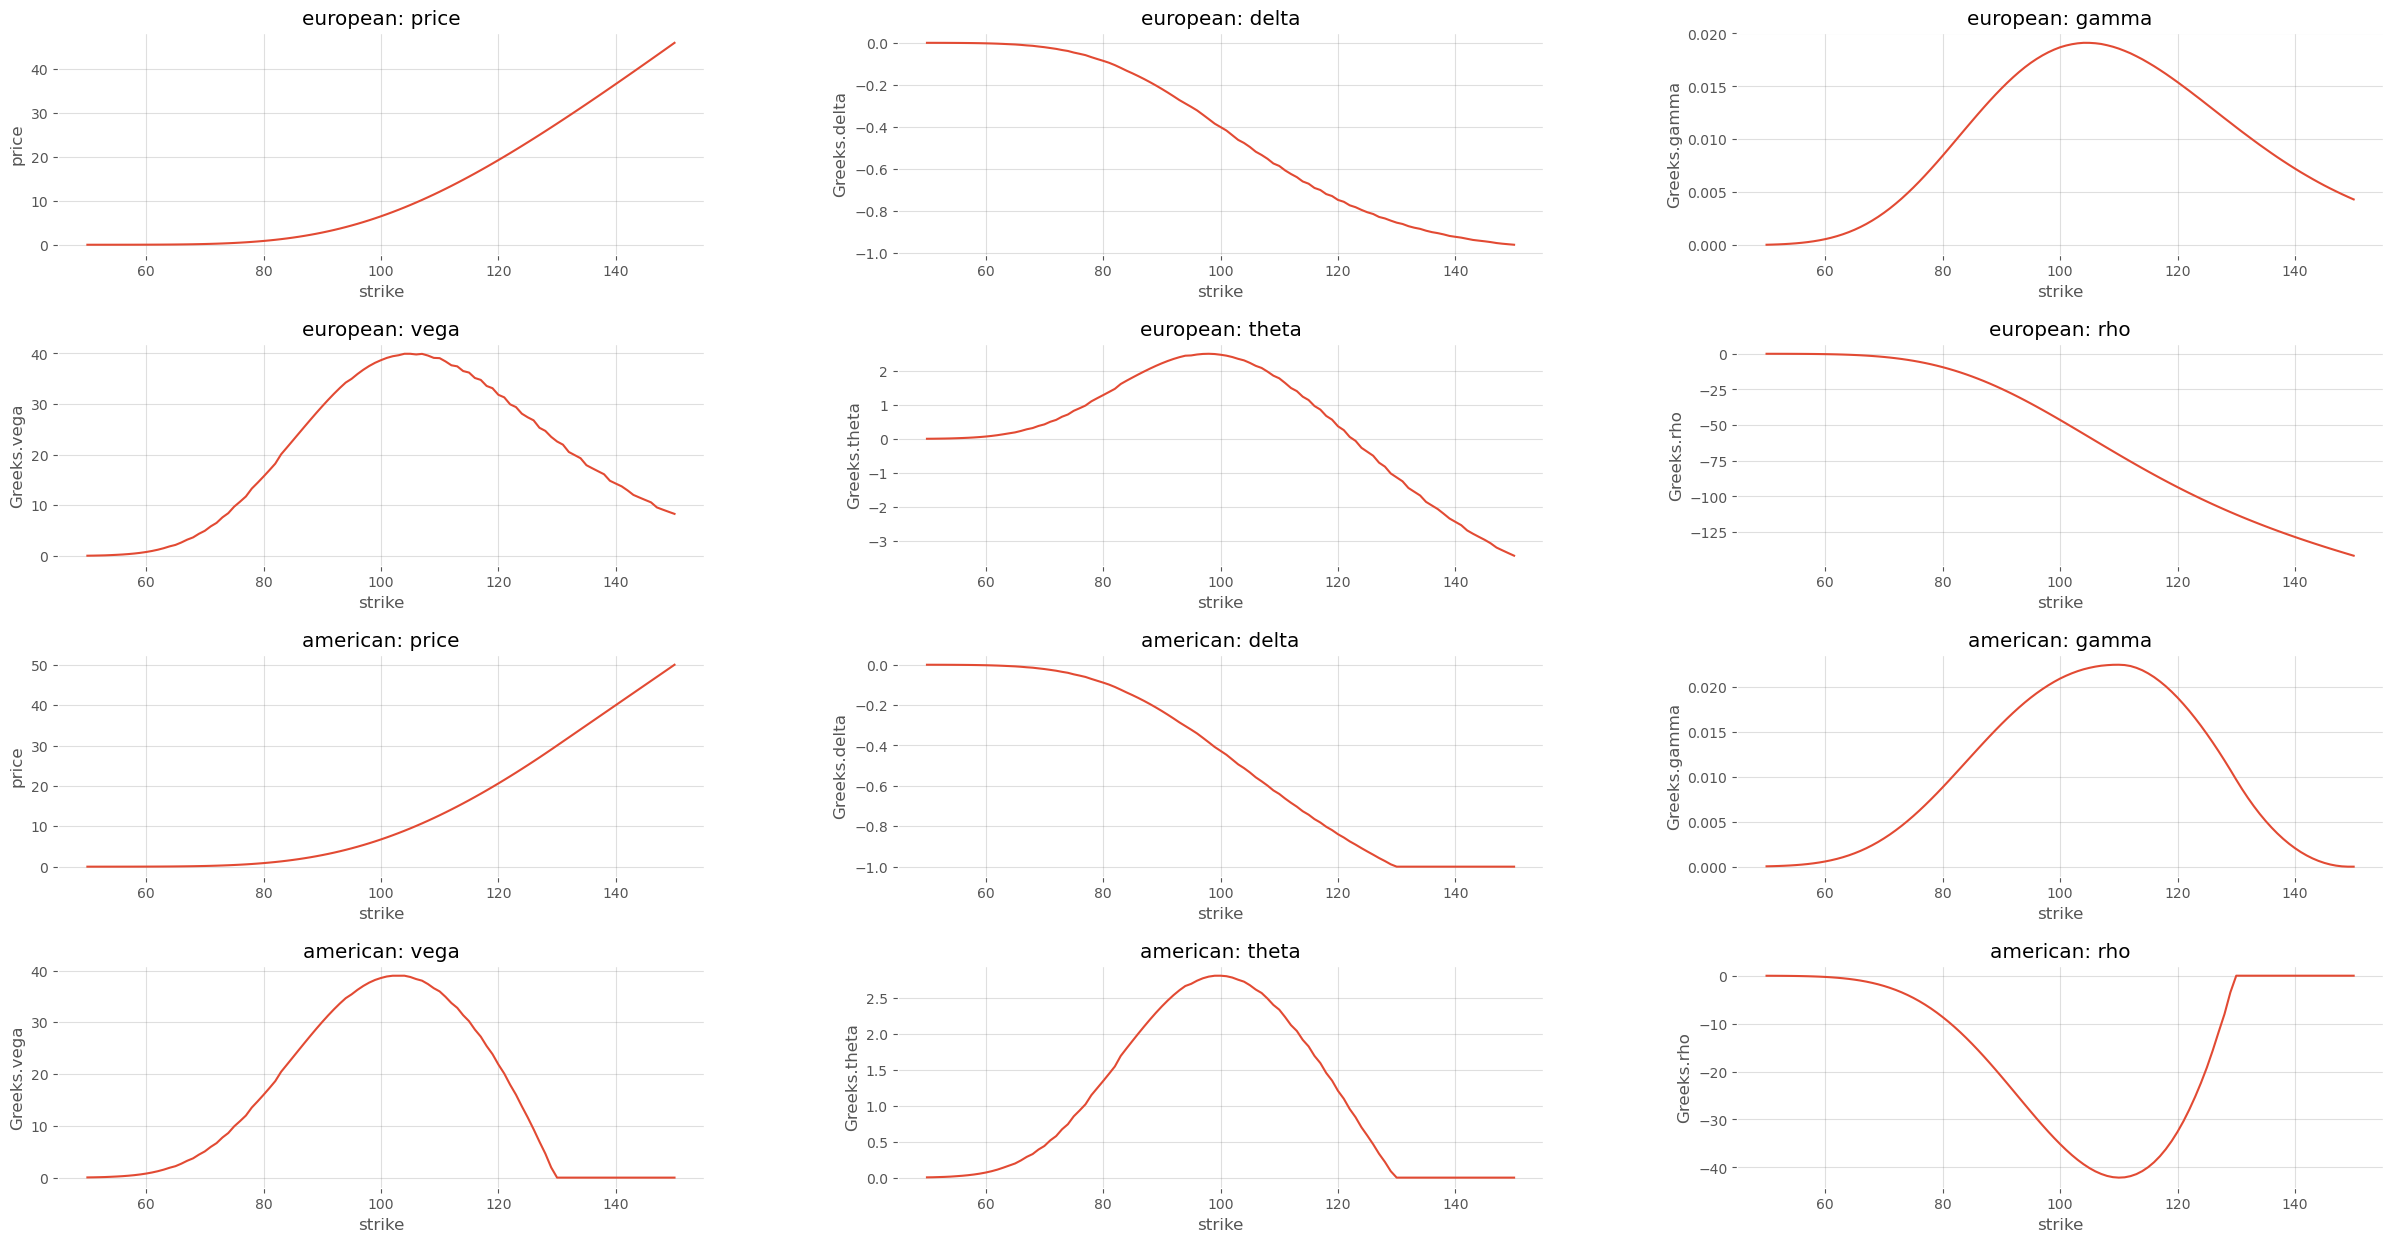

In [7]:
fig, axes = plt.subplots(4, 3)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

plot_index = 0
for option in optionType:
    ax = axes[plot_index]
    ax.plot(strikes, price[f"{option}_{payoff}"])
    ax.set_title(f"{option.value}: price")
    ax.set_xlabel("strike")
    ax.set_ylabel("price")
    plot_index += 1
    for greek, greek_values in greeks_dict[option.value].items():
        ax = axes[plot_index]
        ax.plot(strikes, greek_values)
        ax.set_title(f"{option.value}: {greek.value}")
        ax.set_xlabel("strike")
        ax.set_ylabel(greek)

        plot_index += 1

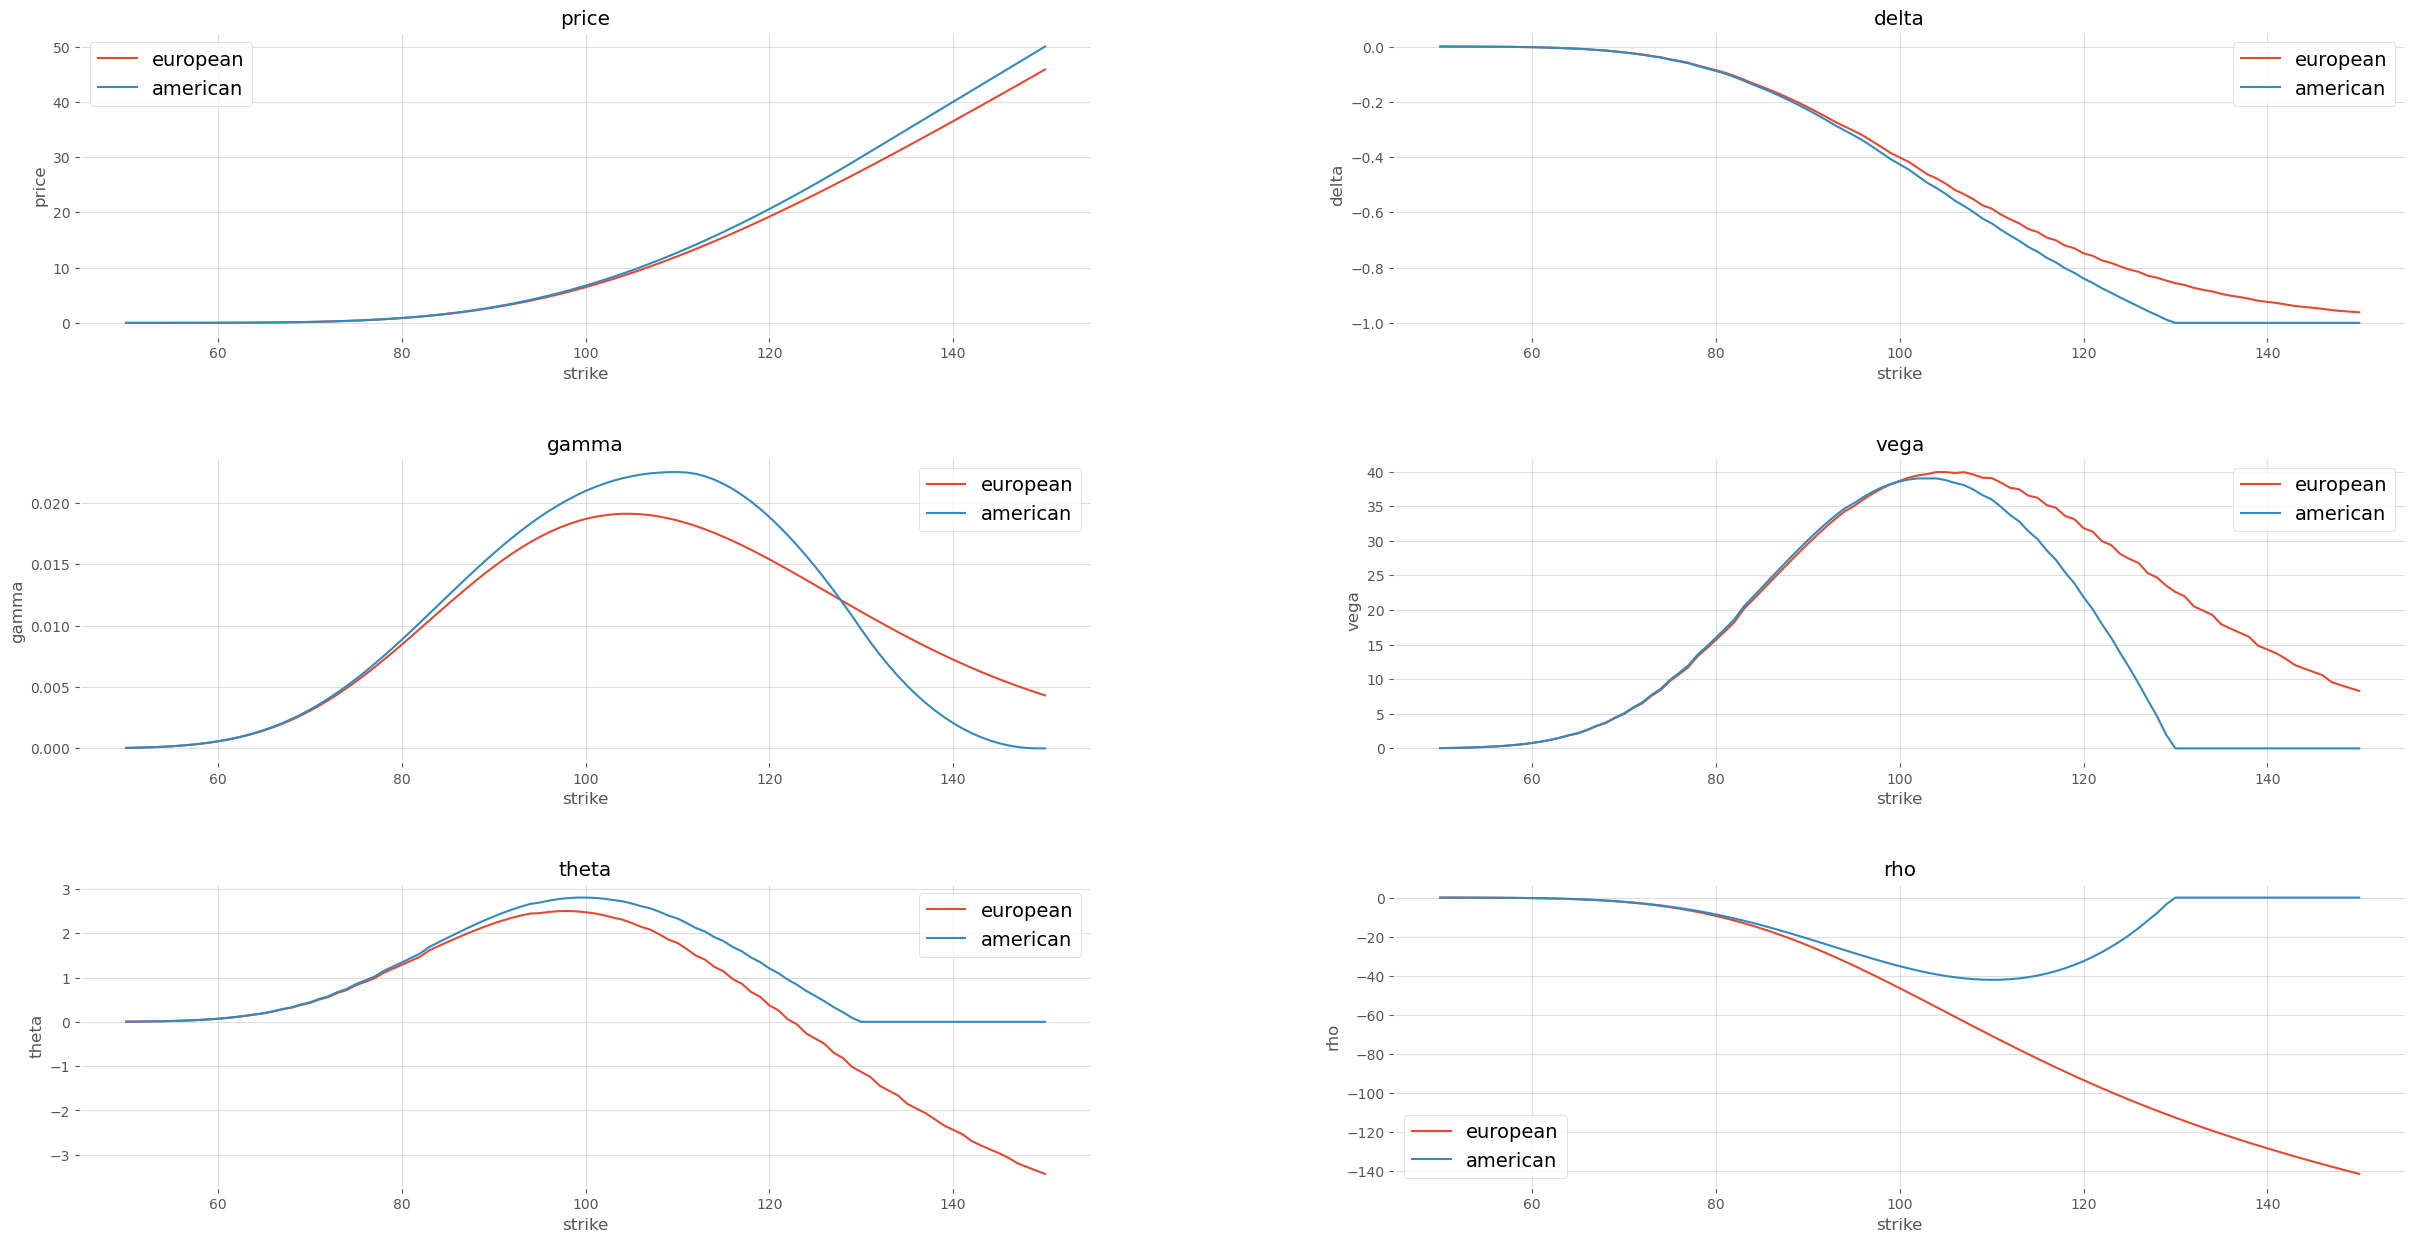

In [8]:
fig, axes = plt.subplots(3, 2)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

plot_index = 0
for option in optionType:
    ax = axes[plot_index]
    ax.plot(strikes, price[f"{option}_{payoff}"], label=option.value)
    ax.set_title("price")
    ax.set_xlabel("strike")
    ax.set_ylabel("price")
    ax.legend()
plot_index += 1

for greek in Greeks:
    for option in optionType:
        ax = axes[plot_index]
        ax.plot(strikes, greeks_dict[option.value][greek.value], label=option.value)
        ax.set_title(f"{greek.value}")
        ax.set_xlabel("strike")
        ax.set_ylabel(greek.value)
        ax.legend()
    plot_index += 1